<a class="anchor" id="0"></a>
# **Predicting Hyperthyroidism Using Medical Features: A Binary Classification Approach**

I am going to load a `thyroid` dataset, which contains many medical features about a patient, and whether they have hyperthyroidism or not as a target. I want to predict whether a patient has hyperthyroidism or not.

<a class="anchor" id="0.1"></a>
# **Table of Contents**


1. [Load the dataset](#1)
2. [Exploratory Analysis](#2)
3. [Random Forest Classifier: no oversampling](#3)
4. [Hyperparameter tuning with GridSearchCV](#4)
5. [Hyperparameter tuning with RandomizedSearch](#5)
6. [Oversampling](#6)
7. [Cross-validation after Oversampling](#7)
8. [Final Conclusions](#8)

# **1. Load the dataset** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)

I am going to use a dataset from a library called "imbalance". I loaded the dataset `thyroid_sick` from the `fetch_datasets` function [reference](https://imbalanced-learn.org/stable/references/generated/imblearn.datasets.fetch_datasets.html#fetch-datasets). 
I Put the features into a dataframe `X` and the target into a series `y`.

Note: the features name are not included in the dataset for the moment

### Importing Libraries and loading the dataset

In [1]:
from imblearn.datasets import fetch_datasets
import ssl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Set the location of CA certificates
ssl._create_default_https_context = ssl._create_unverified_context

thyroid = fetch_datasets()['thyroid_sick']
df=pd.DataFrame(thyroid.data)
df['target']=thyroid.target
y=df['target']
X=df.drop('target',axis=1)

# **1. Exploratory Analysis** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)

Imbalanced-learn's datasets are typically labelled `-1` (the majority class) and `1` (the rare class we are trying to find). Let's change that to `0` (no disease) and `1` (sick). Then, I check the imbalance of the dataset. We can calculate the mean of `y` for that (which is just the proportion of sick patients).

In [2]:
y=y.map({-1:0,1:1})
y.value_counts()
Avg_y= y.mean()
print(f"The proportion of sick patients is {Avg_y*100:.2}%")

The proportion of sick patients is 6.1%


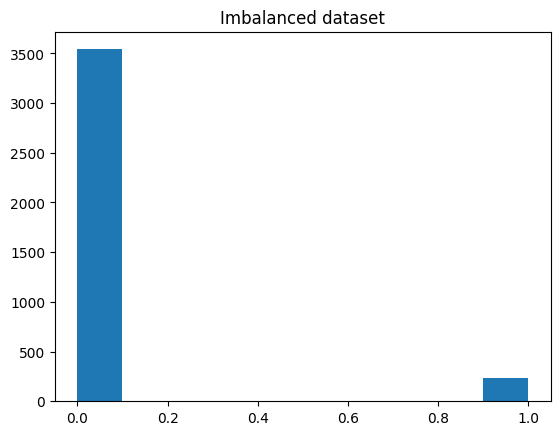

target
0    3541
1     231
Name: count, dtype: int64


In [3]:
plt.hist(y)
plt.title('Imbalanced dataset')
plt.show()
print(y.value_counts())

# **2. Standardizing our splits** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

There is a large disparity between the number of sick and healthy patients. This is a common problem in medical datasets, where the number of healthy patients is much larger than the number of sick patients.

My goal will be to find a good recall (i.e. I want our classifier to find as many positive cases as it can). Using this metric can be dangerous, however, as simply predicting _everyone_ has a bad thyroid will make the recall 100%.

To make sure that our results are consistent as we try different methods we will use a `KFold` object to ensure that we get the same splits each time.
Instantiate a `KFold` object with 5 splits, a random state of 1 (for reproducible results, and `shuffle=True`. I will use this object to split our data into training and validation sets.

In [4]:
kf= KFold(n_splits=5,shuffle=True,random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# **3. Random Forest Classifier: No oversampling** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

I first want to get a baseline result of a classification model by using a random forest classifier. I'll use 100 estimators and a random state of 1 as arguments for the RandomForestClassifier, and then perform cross-validation on the training set with the `cross_val_score` function to get the recall score of the model. I use the `KFold` object I created earlier as the `cv` parameter.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf=RandomForestClassifier(n_estimators=100,random_state=1)
cross_val_score(rf,X_train,y_train,cv=kf,scoring='recall')

array([0.85      , 0.67741935, 0.70833333, 0.96428571, 0.75      ])

The results are pretty decent, and we haven't even started optimizing the model yet. 

# **4. Hyperparameter Tuning with GridSearchCV** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

Let's try to do some hyperparameter tuning. I use the `GridSearchCV` function to find the best hyperparameters for the random forest classifier. I'll use the same parameters as before, but add a `param_grid` parameter with a dictionary of parameters to try (I'll specify a number of estimators going from 10 to 250, and max depth from 4 to 12). We will try different values of `n_estimators` and `max_depth`. Finally I'll use the `KFold` object I created earlier as the `cv` parameter. In conclusion, I'll print the best validation score and the best parameters.

In [6]:
params= {'n_estimators':[10,100,200],'max_depth':[4,6,10,12], 'random_state':[1]}
from sklearn.model_selection import GridSearchCV
grid_no_up=GridSearchCV(rf,param_grid=params,scoring='recall',cv=kf).fit(X_train,y_train)

print(f'The best parameters are {grid_no_up.best_params_} with a score of {grid_no_up.best_score_}')
#Among the k-folds, this score is the average of the recall scores.

The best parameters are {'max_depth': 12, 'n_estimators': 100, 'random_state': 1} with a score of 0.7757219662058372


# **5. Hyperparameter Tuning with RandomizedSearch** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)

Same as before, but using `RandomizedSearchCV` instead of grid search. I'll use a "thicker" list of parameters. As before, I'll print the best score and hyperparameters.

In [7]:
from sklearn.model_selection import RandomizedSearchCV
params = {'n_estimators': list(range(10, 250, 10)),'max_depth': list(range(4, 12, 2)),'random_state': [1]}
grid_no_up=RandomizedSearchCV(rf,param_distributions=params,scoring='recall',cv=kf,n_iter=10).fit(X_train,y_train)

print(f'The best parameters are {grid_no_up.best_params_} with a score of {grid_no_up.best_score_}')

The best parameters are {'random_state': 1, 'n_estimators': 150, 'max_depth': 10} with a score of 0.7657219662058372


### Check model performance against test dataset

Normally we would wait until we had finished our modeling to look at the test set, but an important part of this is to see how oversampling, done incorrectly, can make us too confident in our ability to generalize based off cross-validation. I haven't oversampled yet, so let's just check that the test scores are in line with what we expect from the CV scores above.

In [8]:
from sklearn.metrics import recall_score
recall_score(y_test,grid_no_up.predict(X_test))

0.725

This value should be roughly consistent with the CV results (but probably a bit worse).

# **6. Oversampling** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)

The recall we got without oversampling is the number to beat. Let's just oversample the rows where sick == 1 in the training data and see what happens. 

I'll take the X_train and y_train, extract the rows corresponding to sick people, and add copies of it to the dataframe until the classes become roughly balanced. Then, I'll shuffle the dataframe. Finally I'll check that the upsampling worked by printing the new fraction of sick people.

In [9]:
X_train_copy = X_train.copy()
X_train_copy["target"] = y_train
X_train_sick = X_train_copy.loc[X_train_copy["target"] == 1]
X_train_healthy = X_train_copy.loc[X_train_copy["target"] == 0]
X_train_sick_upsample = pd.concat([X_train_sick]*int(1 / Avg_y))  #it creates fake rows of sick people
X_train_upsample = pd.concat([X_train_healthy, X_train_sick_upsample])
X_train_upsample = X_train_upsample.sample(frac=1)   #Just for shuffling the rows 
y_train_upsample = X_train_upsample["target"]
X_train_upsample = X_train_upsample.drop(columns=["target"])

print(f"Fraction of sick people {y_train_upsample.mean()}")

Fraction of sick people 0.4925586136595311


In [10]:
y_train_upsample.value_counts()

target
0    2489
1    2416
Name: count, dtype: int64

# **7. Cross-validation after Oversampling** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

Let's cross-validate with the new data, using grid search. 


In [11]:
params = {'n_estimators': [50, 100, 200],'max_depth': [4, 6, 10, 12],'random_state': [13]}
grid_naive_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(X_train_upsample, y_train_upsample)
print(f"The best parameters are {grid_naive_up.best_params_} with a score of {grid_naive_up.best_score_}")
print(f"All mean scores: {grid_naive_up.cv_results_['mean_test_score']}")

The best parameters are {'max_depth': 10, 'n_estimators': 50, 'random_state': 13} with a score of 1.0
All mean scores: [0.92170799 0.92997794 0.9324437  0.98714569 0.990236   0.99464028
 1.         1.         1.         1.         1.         1.        ]


The recall is really good (even amazing!). 
Let's now take a look at how it does on:
* The training set as a whole (once we eliminate the upsampling)
* On the test set

In [12]:
recal_test=recall_score(y_test,grid_naive_up.predict(X_test))
recall_train=recall_score(y_train,grid_naive_up.predict(X_train))
print(f"The recall score for the test set is {recal_test:.2} and for the training set is {recall_train:.2}")

The recall score for the test set is 0.9 and for the training set is 1.0


### Confusion Matrix

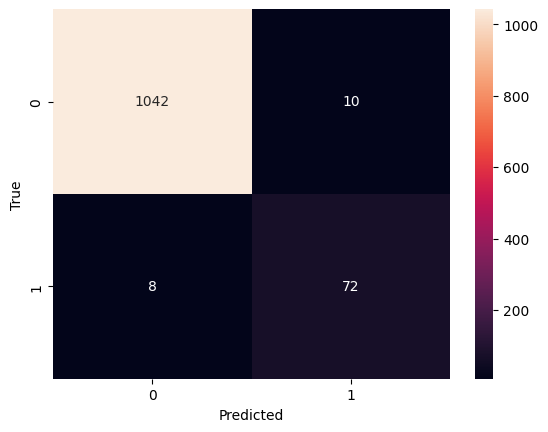

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, grid_naive_up.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### AUROC
I'm going to try with this classification metric to see if there are any more improvements.

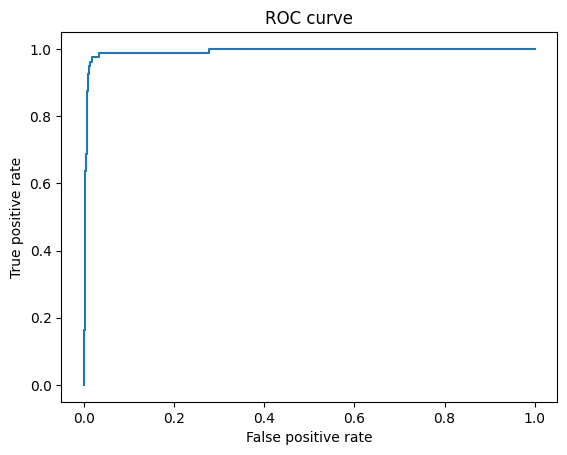

0.9922528517110267

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_pred = grid_naive_up.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
roc_auc_score(y_test, y_pred)

# **8. Final Conclusion** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

Time for some final good and bad news:

* Good: the recall on the test set went up! It should be significantly better than the original value without upscaling.
* Bad: our confidence in the cross-valdation results went down. With no upsampling, the validation recall was a good estimate of the test validation. With upsampling, the validation recall way higher than the test recall.
* AUROC metric: gives us the best score. 